## Question 1. Clustering:
**(A)** a. Extract ResNet-18 features for Ants vs. Bees training data from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html . Visualize and pre-process the data as appropriate.


**Loading Data**

In [1]:
import urllib.request
import zipfile
import os

# URL of the dataset
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
# Destination directory to save the dataset
download_dir = "/content/hymenoptera_data/hymenoptera_data"

# Download the dataset
urllib.request.urlretrieve(url, "hymenoptera_data.zip")

# Extract the dataset
with zipfile.ZipFile("hymenoptera_data.zip", 'r') as zip_ref:
    zip_ref.extractall(download_dir)

# Check the contents of the extracted directory
print(os.listdir(download_dir))


['hymenoptera_data']


In [2]:
import torch
import torchvision
from torchvision import datasets, transforms

# Define data directory
data_dir = "/content/hymenoptera_data/hymenoptera_data"

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Check the classes in the dataset
print(dataset.classes)


['hymenoptera_data']


**Extracting ResNet-18 features**

In [3]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms

# Define data directory
data_dir = "/content/hymenoptera_data/hymenoptera_data/hymenoptera_data/train"

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Remove the last fully connected layer (classifier)
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))

# Placeholder for extracted features and labels
features = []
labels = []

# Set model to evaluation mode
resnet18.eval()

# Extract features for each image in the dataset
with torch.no_grad():
    for inputs, labels_batch in data_loader:
        features_batch = resnet18(inputs)
        features.append(features_batch.squeeze().numpy())
        labels.append(labels_batch.item())

# Convert lists to numpy arrays
features = torch.tensor(features)
labels_array = torch.tensor(labels)

# Check the shape of extracted features
print("Shape of extracted features:", features.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.5MB/s]


Shape of extracted features: torch.Size([244, 512])


<ipython-input-3-c6c1b33985b8>:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  features = torch.tensor(features)


**Visualizing and pre-processing of the data**

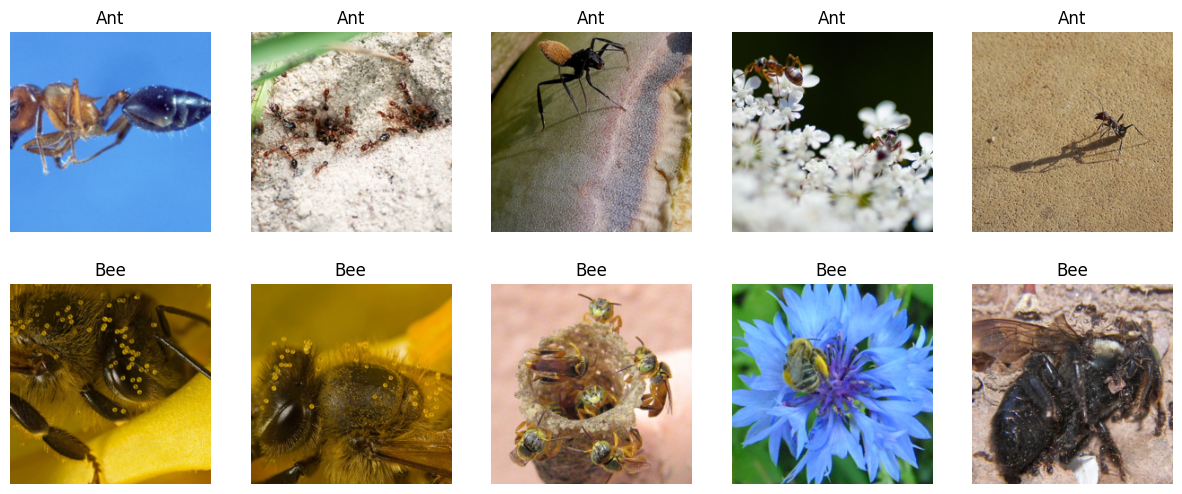

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define function to visualize sample images from each class
def visualize_samples(dataset):
    ants_samples = []
    bees_samples = []

    # Iterate through the dataset to separate ants and bees samples
    for sample, label in dataset:
        if label == 0 and len(ants_samples) < 5:
            ants_samples.append(sample)
        elif label == 1 and len(bees_samples) < 5:
            bees_samples.append(sample)

    # Plot sample images
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    for i in range(5):
        # Reverse normalization
        ant_image = np.transpose(ants_samples[i].numpy(), (1, 2, 0))
        ant_image = ant_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        ant_image = np.clip(ant_image, 0, 1)
        bee_image = np.transpose(bees_samples[i].numpy(), (1, 2, 0))
        bee_image = bee_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        bee_image = np.clip(bee_image, 0, 1)

        axes[0, i].imshow(ant_image)
        axes[0, i].set_title('Ant')
        axes[0, i].axis('off')
        axes[1, i].imshow(bee_image)
        axes[1, i].set_title('Bee')
        axes[1, i].axis('off')
    plt.show()

# Visualize sample images
visualize_samples(dataset)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Convert features to a NumPy array
features_array = features.numpy()

# Get the number of features
num_features = features_array.shape[1]

# Perform standardization of features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# Check the shape of scaled features
print("Shape of scaled features:", features_scaled.shape)


Shape of scaled features: (244, 512)


## **(b)**
**Train k-means, and find the appropriate number of k using the silhouette method.**

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 3: Train k-means with different values of k and evaluate silhouette score
min_k = 2  # Minimum number of clusters
max_k = 10  # Maximum number of clusters

best_k = min_k
best_silhouette_score = -1

for k in range(min_k, max_k + 1):
    # Train k-means model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Set n_init explicitly
    kmeans.fit(features_scaled)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)

    # Print silhouette score for each k
    print(f"Silhouette score for k={k}: {silhouette_avg}")

    # Update best_k and best_silhouette_score if current score is higher
    if silhouette_avg > best_silhouette_score:
        best_k = k
        best_silhouette_score = silhouette_avg

# Step 4: Choose the value of k with the highest silhouette score
print(f"\nBest number of clusters (k) based on silhouette score: {best_k}")


Silhouette score for k=2: 0.05926084890961647
Silhouette score for k=3: 0.052661873400211334
Silhouette score for k=4: 0.03456437960267067
Silhouette score for k=5: 0.0385465994477272
Silhouette score for k=6: 0.034496475011110306
Silhouette score for k=7: 0.02845289744436741
Silhouette score for k=8: 0.022059841081500053
Silhouette score for k=9: 0.022636275738477707
Silhouette score for k=10: 0.024363763630390167

Best number of clusters (k) based on silhouette score: 2


## **(C)**
**Visualize a few samples in each cluster to see what is common in images from a cluster.**

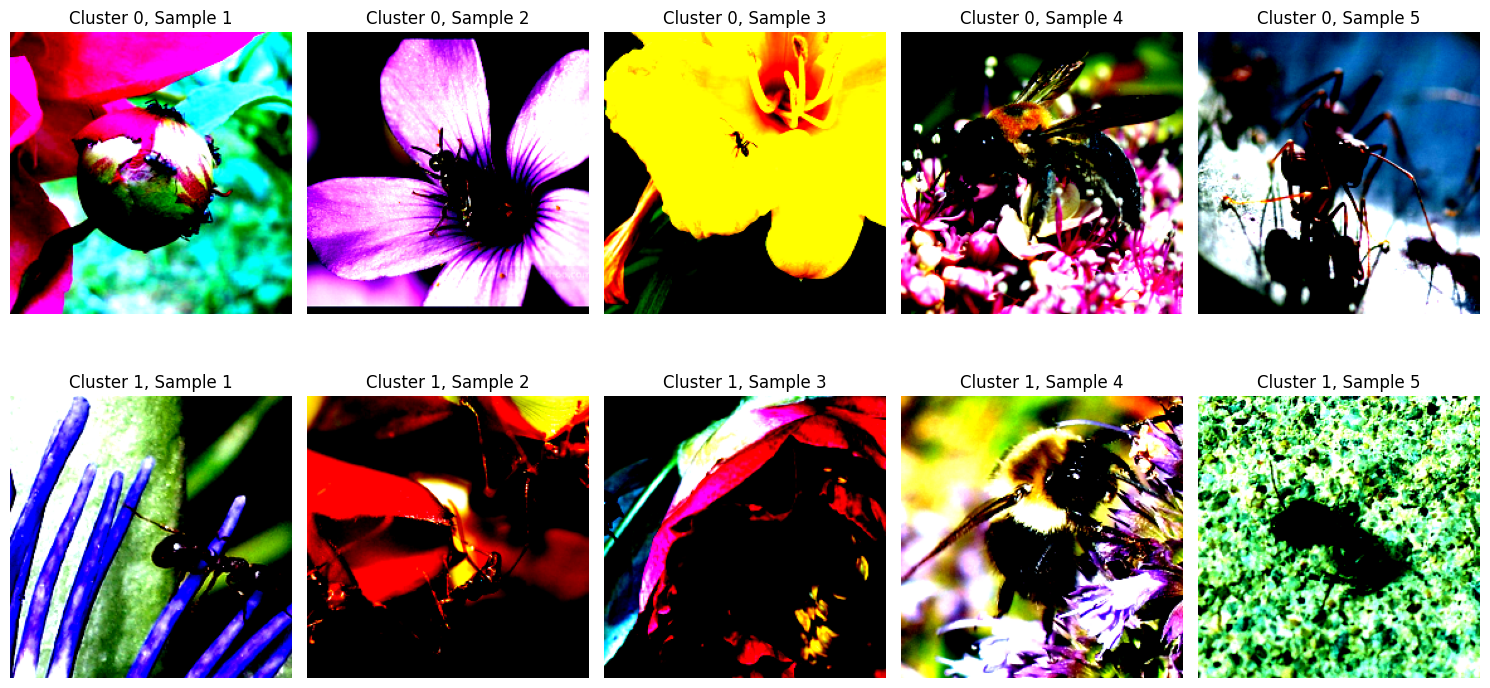

In [18]:
import random

# Train k-means with the best number of clusters
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)  # Set n_init explicitly
best_kmeans.fit(features_scaled)

# Create a dictionary to store indices of samples for each cluster
cluster_indices = {i: [] for i in range(best_k)}

# Assign each sample to its corresponding cluster
for idx, label in enumerate(best_kmeans.labels_):
    cluster_indices[label].append(idx)

# Visualize a few samples from each cluster
num_samples_per_cluster = 5  # Number of samples to visualize from each cluster
plt.figure(figsize=(15, 8))
for cluster, indices in cluster_indices.items():
    sample_indices = random.sample(indices, min(num_samples_per_cluster, len(indices)))
    for i, sample_idx in enumerate(sample_indices):
        plt.subplot(best_k, num_samples_per_cluster, i + 1 + cluster * num_samples_per_cluster)
        image = dataset[sample_idx][0].permute(1, 2, 0)
        # Ensure the image data falls within the valid range [0, 1]
        image = np.clip(image, 0, 1)
        plt.imshow(image)  # Display the image
        plt.title(f"Cluster {cluster}, Sample {i+1}")
        plt.axis('off')
plt.tight_layout()
plt.show()


**Observation:** Cluster 0 is having ants data and cluster 1 is having bees data.

In [19]:
from sklearn.metrics import silhouette_score

kmeans_labels = best_kmeans.labels_
# Compute silhouette score for k-means
silhouette_kmeans = silhouette_score(features_scaled, kmeans_labels)
print(silhouette_kmeans)

0.05926085


**Observation:** The silhouette score ranges from -1 to 1.
1. A score close to +1 indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
2. A score of 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters.
3. A score close to -1 indicates that the object is more similar to neighboring clusters than to its own cluster.

as our score is near 0, point 2 is correct for our case.

## **(d)**
**Examine cluster purity in terms of whether each cluster is either predominantly ants or bees, or amix of both?**

In [20]:
# Function to calculate cluster purity
def calculate_cluster_purity(cluster_indices, labels):
    cluster_purity = {}
    for cluster, indices in cluster_indices.items():
        cluster_labels = [labels[idx] for idx in indices]
        unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
        dominant_label = unique_labels[np.argmax(label_counts)]
        purity = label_counts.max() / len(indices)
        cluster_purity[cluster] = (purity, dominant_label)
    return cluster_purity

# Calculate cluster purity
cluster_purity = calculate_cluster_purity(cluster_indices, labels_array)

# Print cluster purity
for cluster, (purity, dominant_label) in cluster_purity.items():
    print(f"Cluster {cluster}: Purity={purity}, Dominant Label={dominant_label}")


Cluster 0: Purity=0.9743589743589743, Dominant Label=1
Cluster 1: Purity=0.9448818897637795, Dominant Label=0


**Observations:** both clusters are not entirely pure, but they each have a dominant class. Cluster 0 is predominantly bees, while Cluster 1 is predominantly ants.

##(e)
**Train DBSCAN, and see if by varying MinPts and ε, you can get the same number of clusters as kmeans.**

**Note:** Trying to find optimal min_pts and epsilon using k-distance graph and number of features.

In [21]:
num_features = len(features[0])
print(num_features)

512


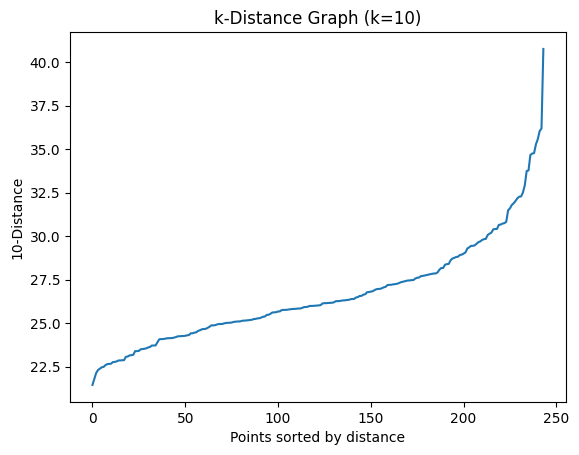

In [22]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Compute the distance to the k-nearest neighbors for each point
k = 10  # Choose the number of neighbors (k)
nbrs = NearestNeighbors(n_neighbors=k).fit(features_scaled)
distances, _ = nbrs.kneighbors(features_scaled)

# Sort distances and plot the k-distance graph
sorted_distances = np.sort(distances[:, -1])
plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-Distance')
plt.title(f'k-Distance Graph (k={k})')
plt.show()


**Finding Optimal Epsilon:**
1. Significant change in slope or curvature, indicates a transition from points within a dense region to points in the sparse region.
2. Choose the epsilon value corresponding to this point. This value can be selected such that it captures the distance at which the transition occurs.


In [23]:
from sklearn.cluster import DBSCAN


# Train DBSCAN with different values of MinPts and ε
#min_samples_range = [2, 5, 10, 15, 50, 100,200, 380, 390, 571, 513]  # Range of MinPts values to try
#eps_range = [0.25, 0.5, 1.0, 1.5, 2.0, 22, 24, 28, 26, 32, 34, 36]       # Range of ε values to try


min_samples_range = [2, 3, 1, 4, 513]  # Range of MinPts values to try
eps_range = [20, 22, 24, 28, 26, 23]       # Range of ε values to try


best_dbscan = None
best_num_clusters = float('inf')

for min_samples in min_samples_range:
    for eps in eps_range:
        # Train DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(features_scaled)

        # Calculate the number of clusters (excluding noise points)
        num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

        # Print number of clusters for each combination of parameters
        print(f"MinPts={min_samples}, ε={eps}: Number of clusters = {num_clusters}")

        # Update best_dbscan if the number of clusters is the same as k-means
        if num_clusters == best_k:
            best_dbscan = dbscan
            break

# Step 3: Compare the number of clusters obtained with k-means
if best_dbscan is not None:
    print("\nDBSCAN with the same number of clusters as k-means found.")
else:
    print("\nDBSCAN with the same number of clusters as k-means not found. Try different parameters.")


MinPts=2, ε=20: Number of clusters = 8
MinPts=2, ε=22: Number of clusters = 3
MinPts=2, ε=24: Number of clusters = 1
MinPts=2, ε=28: Number of clusters = 1
MinPts=2, ε=26: Number of clusters = 1
MinPts=2, ε=23: Number of clusters = 3
MinPts=3, ε=20: Number of clusters = 3
MinPts=3, ε=22: Number of clusters = 2
MinPts=1, ε=20: Number of clusters = 227
MinPts=1, ε=22: Number of clusters = 182
MinPts=1, ε=24: Number of clusters = 111
MinPts=1, ε=28: Number of clusters = 31
MinPts=1, ε=26: Number of clusters = 51
MinPts=1, ε=23: Number of clusters = 146
MinPts=4, ε=20: Number of clusters = 2
MinPts=513, ε=20: Number of clusters = 0
MinPts=513, ε=22: Number of clusters = 0
MinPts=513, ε=24: Number of clusters = 0
MinPts=513, ε=28: Number of clusters = 0
MinPts=513, ε=26: Number of clusters = 0
MinPts=513, ε=23: Number of clusters = 0

DBSCAN with the same number of clusters as k-means found.


**Observation:** The optimal Min_pts = 3 and epsilon = 22, for which number of cluster in DBSCAN and K means is same.

# **(f)**
# **Find out if there is a good metric for DBSCAN clustering, and if so, then use it.**

**WEB SEARCH INFORMATION:** https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/ suggest that Silhouette score and Adjusted rand score is a good metric to observe DBSCAN clustering.

Step 1: Using Optimal Parameters for DBSCAN i.e. **min_pts = 3** and **epsilon = 22**

In [24]:
from sklearn.cluster import DBSCAN
import numpy as np

# Optimal parameters
optimal_min_samples = 3
optimal_eps = 22

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_labels = dbscan.fit_predict(features_scaled)

# Print the number of clusters
num_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print("Number of clusters in DBSCAN:", num_clusters_dbscan)


Number of clusters in DBSCAN: 2


In [25]:
#existing k-means model trained with the optimal number of clusters
kmeans_labels = kmeans.predict(features_scaled)

Step 2: We'll compute the following commonly used clustering evaluation metrics:

1. Silhouette Score
2. Davies-Bouldin Index (DBI)
3. Dunn Index
4. Adjusted Rand Index(ARI)

In [26]:
print("Number of samples in features_scaled:", len(features_scaled))
print("Number of samples in dbscan_labels:", len(dbscan_labels))
print("Number of samples in kmeans_labels:", len(kmeans_labels))


Number of samples in features_scaled: 244
Number of samples in dbscan_labels: 244
Number of samples in kmeans_labels: 244


In [27]:
import os

# Get the class labels from the directory structure
true_labels = []
class_names = sorted(os.listdir(data_dir))  # Assumes each subdirectory represents a class
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    true_labels.extend([class_name] * num_samples)

# Convert true labels to numeric format (if needed)
# For DBSCAN, the true labels should be in numeric format, so you might need to encode them
# For example, using LabelEncoder from sklearn.preprocessing

# Print the true labels
print("True labels:", true_labels)


True labels: ['ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'a

In [28]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN, KMeans

# Compute silhouette score for DBSCAN
silhouette_dbscan = silhouette_score(features_scaled, dbscan_labels)

# Compute Davies-Bouldin Index (DBI) for DBSCAN
dbi_dbscan = davies_bouldin_score(features_scaled, dbscan_labels)

# Compute Dunn Index for DBSCAN
min_distance_dbscan = pairwise_distances(features_scaled).min()
max_diameter_dbscan = max([pairwise_distances(features_scaled[dbscan_labels == label]).max() for label in set(dbscan_labels)])
dunn_dbscan = min_distance_dbscan / max_diameter_dbscan

# Compute silhouette score for k-means
silhouette_kmeans = silhouette_score(features_scaled, kmeans_labels)

# Compute Davies-Bouldin Index (DBI) for k-means
dbi_kmeans = davies_bouldin_score(features_scaled, kmeans_labels)

# Compute Dunn Index for k-means
min_distance_kmeans = pairwise_distances(features_scaled).min()
max_diameter_kmeans = max([pairwise_distances(features_scaled[kmeans_labels == label]).max() for label in set(kmeans_labels)])
dunn_kmeans = min_distance_kmeans / max_diameter_kmeans

# Print evaluation metrics for both DBSCAN and k-means
print("Evaluation Metrics for DBSCAN:")
print(f"Silhouette Score: {silhouette_dbscan}")
print(f"Davies-Bouldin Index (DBI): {dbi_dbscan}")
print(f"Dunn Index: {dunn_dbscan}")
print("\n")

print("Evaluation Metrics for k-means:")
print(f"Silhouette Score: {silhouette_kmeans}")
print(f"Davies-Bouldin Index (DBI): {dbi_kmeans}")
print(f"Dunn Index: {dunn_kmeans}")


Evaluation Metrics for DBSCAN:
Silhouette Score: -0.044865772128105164
Davies-Bouldin Index (DBI): 4.5586517921678515
Dunn Index: 0.0


Evaluation Metrics for k-means:
Silhouette Score: 0.024363763630390167
Davies-Bouldin Index (DBI): 3.5773227809739696
Dunn Index: 0.0


**Observations:** Based on these metrics, neither DBSCAN nor k-means seems to perform well on this dataset. Both algorithms exhibit low silhouette scores, high Davies-Bouldin Index values, and a Dunn Index of 0, indicating suboptimal clustering quality.

# Calculating ARI for DBSCAN

In [29]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Assuming true_labels and dbscan_labels are lists or arrays
# Check which label set has more samples
if len(true_labels) > len(dbscan_labels):
    # Remove one sample from true_labels
    true_labels = np.random.choice(true_labels, len(dbscan_labels), replace=False)
elif len(true_labels) < len(dbscan_labels):
    # Remove one sample from dbscan_labels
    dbscan_labels = np.random.choice(dbscan_labels, len(true_labels), replace=False)

# Now both label sets have the same number of samples
# Calculate Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, dbscan_labels)
print("Adjusted Rand Index (ARI):", ari)


Adjusted Rand Index (ARI): -0.0027751897374345574


**Adjusted Rand Index(ARI):**
The Adjusted Rand Index (ARI) measures the similarity between two clustering results, where a higher value indicates a higher similarity. The ARI score ranges from -1 to 1:

1. A score close to 1 indicates that the two clustering results are very similar.
2. A score around 0 indicates that the clustering results are random.
3. A score close to -1 indicates that the clustering results are dissimilar.

## **(g)**

**Repeat part c and comment on which one is more appropriate clustering method for this data.**

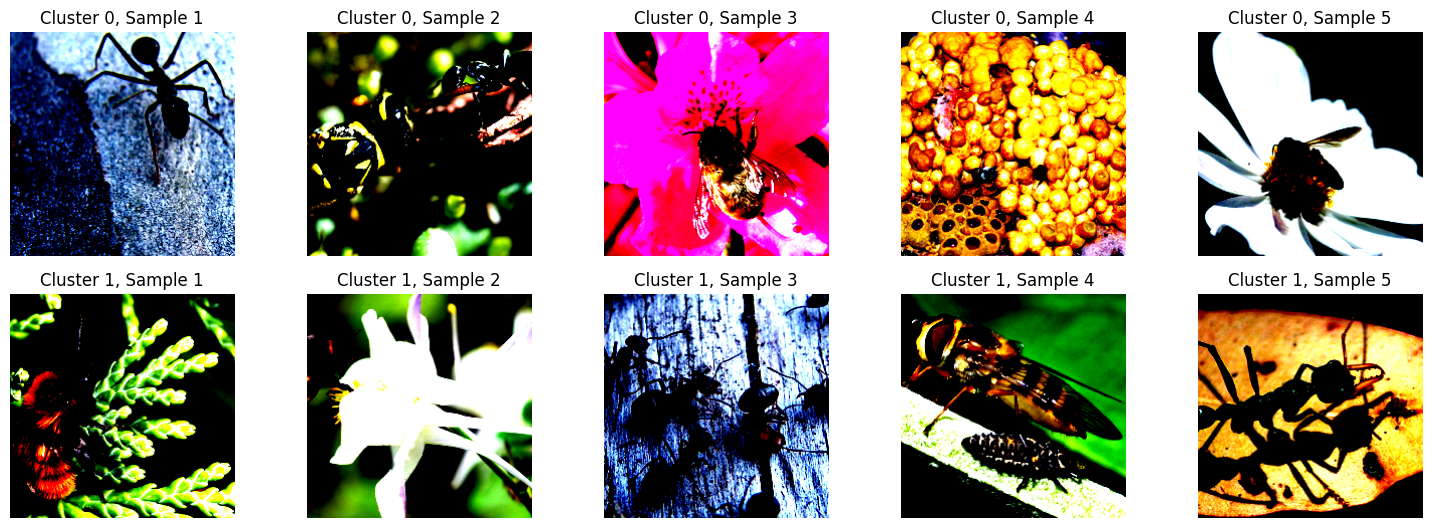

In [30]:
# Visualize a few samples from each cluster (similar to what we did before)
# Create a dictionary to store indices of samples for each cluster
dbscan_cluster_indices = {i: [] for i in set(dbscan_labels)}

# Assign each sample to its corresponding cluster
for idx, label in enumerate(dbscan_labels):
    dbscan_cluster_indices[label].append(idx)

# Visualize a few samples from each cluster
num_samples_per_cluster = 5  # Number of samples to visualize from each cluster
num_clusters = len(dbscan_cluster_indices)

if num_clusters > 0:
    plt.figure(figsize=(15, 8))
    idx = 1
    for cluster, indices in dbscan_cluster_indices.items():
        # Skip outliers (cluster label -1)
        if cluster == -1:
            continue
        sample_indices = np.random.choice(indices, min(num_samples_per_cluster, len(indices)), replace=False)
        for i, sample_idx in enumerate(sample_indices):
            plt.subplot(num_clusters, num_samples_per_cluster, idx)
            image = dataset[sample_idx][0].permute(1, 2, 0)
            # Clip pixel values to the valid range [0, 1]
            image = np.clip(image, 0, 1)
            plt.imshow(image)  # Display the image
            plt.title(f"Cluster {cluster}, Sample {i+1}")
            plt.axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()
else:
    print("No clusters found.")


## (h)
**Examine cluster purity in terms of whether each cluster is either predominantly ants or bees, or amix of both?**

In [31]:
# Create dictionaries to store counts of ants and bees in each cluster
ants_counts = {cluster: 0 for cluster in set(dbscan_labels)}
bees_counts = {cluster: 0 for cluster in set(dbscan_labels)}

# Count the number of ants and bees in each cluster
for idx, label in enumerate(dbscan_labels):
    if label != -1:  # Exclude outliers
        if labels_array[idx] == 0:  # Ant
            ants_counts[label] += 1
        else:  # Bee
            bees_counts[label] += 1

# Calculate the total number of samples in each cluster
cluster_sizes = {cluster: ants_counts[cluster] + bees_counts[cluster] for cluster in ants_counts}

# Print cluster purity
for cluster in cluster_sizes:
    if cluster >= 0:  # Exclude outliers (cluster -1)
        total_samples = cluster_sizes[cluster]
        if total_samples != 0:
            ants_percentage = ants_counts[cluster] / total_samples * 100
            bees_percentage = bees_counts[cluster] / total_samples * 100
            print(f"Cluster {cluster}: Ants: {ants_percentage:.2f}%, Bees: {bees_percentage:.2f}%")
        else:
            print(f"Cluster {cluster}: No samples")

Cluster 0: Ants: 100.00%, Bees: 0.00%
Cluster 1: Ants: 3.33%, Bees: 96.67%


## (i)
**Using the ants or bees label to color the samples and visualize the t-sne embedding in 2D.**

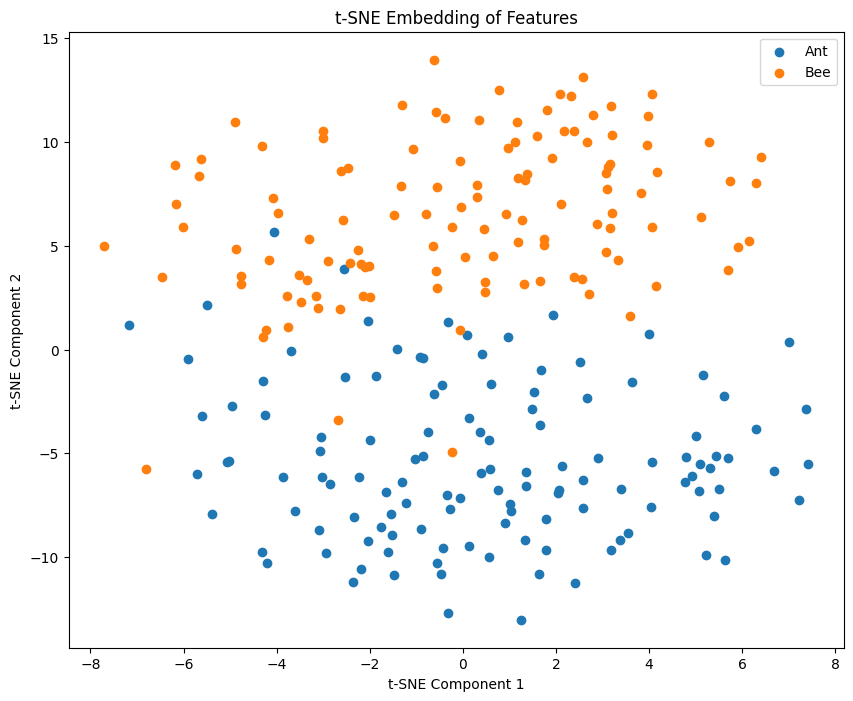

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features_scaled)

# Plot t-SNE embedding with colors representing ants or bees labels
plt.figure(figsize=(10, 8))
for label in np.unique(labels_array):
    plt.scatter(tsne_features[labels_array == label, 0], tsne_features[labels_array == label, 1], label=label)
plt.title('t-SNE Embedding of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(['Ant', 'Bee'])
plt.show()


## **Question 2. PCA**

a. Train PCA on the data from the previous question.

**Answer:** Principal component analysis (PCA) is a dimensionality reduction and machine learning method used to simplify a large data set into a smaller set while still maintaining significant patterns and trends.

e.g. when the feature space contains too many irrelevant or redundant features. The aim is to find the intrinsic dimensionality of the data.

**Reference:** https://builtin.com/data-science/step-step-explanation-principal-component-analysis

In [33]:
from sklearn.decomposition import PCA

# Initialize PCA with desired number of components
num_components = 2  # Choose the number of components
pca = PCA(n_components=num_components)

# Fit PCA to the standardized features
pca.fit(features_scaled)

# Transform the standardized features using the fitted PCA
pca_features = pca.transform(features_scaled)


## **(b)**
**Plot the variance explained versus PCA dimensions.**

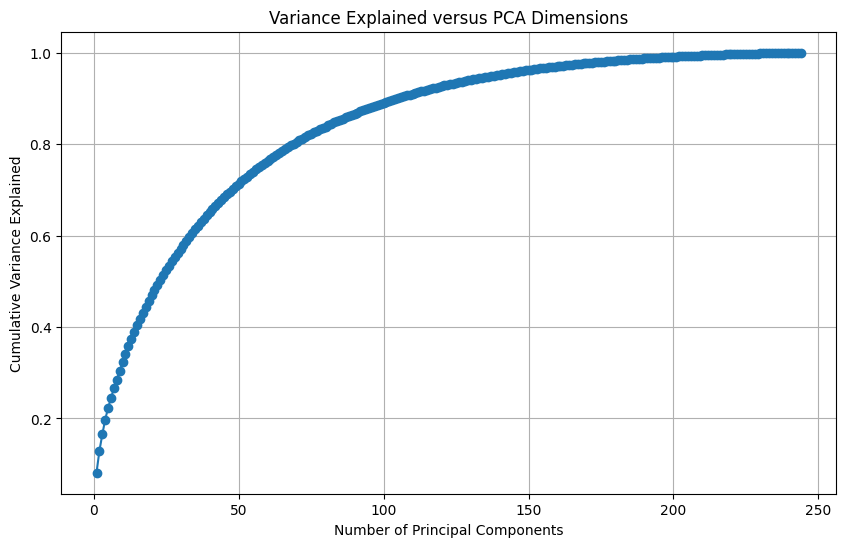

In [34]:
import matplotlib.pyplot as plt

# Initialize PCA with all components
pca_all = PCA()

# Fit PCA to the standardized features
pca_all.fit(features_scaled)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca_all.explained_variance_ratio_)

# Plot the variance explained versus PCA dimensions
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained versus PCA Dimensions')
plt.grid(True)
plt.show()


**Observations:**  This plot helps you understand how much of the variance in the original data is captured by each principal component and how many principal components are needed to represent the data adequately.

We see a rapid drop-off in variance explained after a certain number of dimensions (elbow point).

## **(c)**
**Reconstruct the data with various numbers of PCA dimensions, and compute the NRMSE.**

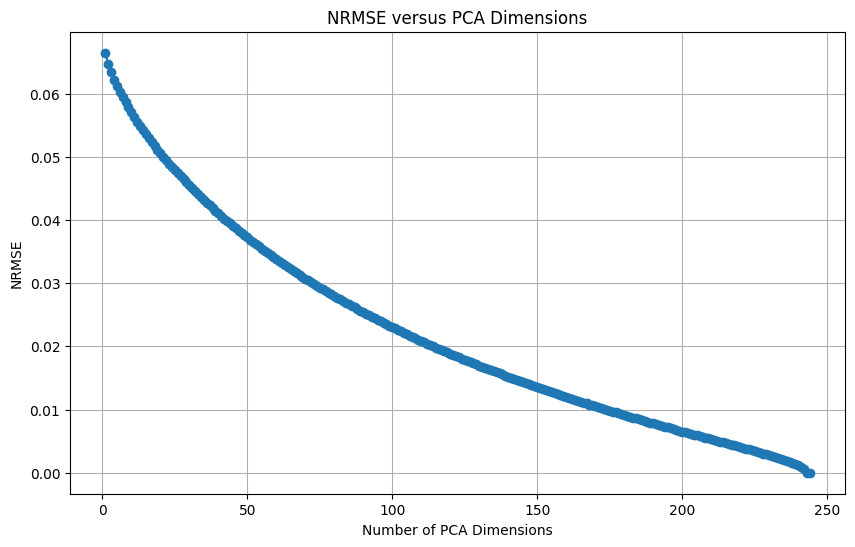

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a function to compute NRMSE
def compute_nrmse(original_data, reconstructed_data):
    mse = mean_squared_error(original_data, reconstructed_data)
    rmse = np.sqrt(mse)
    data_range = np.max(original_data) - np.min(original_data)
    nrmse = rmse / data_range
    return nrmse

# Initialize lists to store NRMSE values
nrmse_values = []

# Loop over different numbers of PCA dimensions
for n_components in range(1, len(cumulative_variance_ratio) + 1):
    # Initialize PCA with the current number of components
    pca = PCA(n_components=n_components)

    # Fit PCA to the standardized features and transform them
    reduced_features = pca.fit_transform(features_scaled)

    # Reconstruct the data by inverse transforming the reduced features
    reconstructed_features = pca.inverse_transform(reduced_features)

    # Compute NRMSE
    nrmse = compute_nrmse(features_scaled, reconstructed_features)

    # Append NRMSE to the list
    nrmse_values.append(nrmse)

# Plot NRMSE versus number of PCA dimensions
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(nrmse_values) + 1), nrmse_values, marker='o')
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('NRMSE')
plt.title('NRMSE versus PCA Dimensions')
plt.grid(True)
plt.show()


**Observation:** The NRMSE (Normalized Root Mean Squared Error) is a measure of how accurately the reconstructed data matches the original data. Comparing the NRMSE for different numbers of PCA dimensions helps you evaluate the trade-off between dimensionality reduction and reconstruction accuracy.

## **Question 3. Non-linear dimension reduction:**

**(a). Train KPCA on the data from Q1.**

**Answer:** KPCA uses a kernel function to map the data into a higher-dimensional space where non-linear relationships can be more easily captured.

In [16]:
from sklearn.decomposition import KernelPCA

# Define the number of KPCA dimensions to consider
num_dimensions = min(10, num_features)  # Up to 10 dimensions

# Initialize lists to store variance explained and number of dimensions
variance_explained = []
kpca_dimensions = []

# Perform KPCA for each number of dimensions
for n in range(1, num_dimensions + 1):
    # Initialize KPCA with 'rbf' kernel
    kpca = KernelPCA(n_components=n, kernel='rbf')

    # Fit KPCA on scaled features
    kpca.fit(features_scaled)

    # Get the eigenvalues of the kernel matrix
    eigenvalues = kpca.eigenvalues_

    # Calculate the variance explained by KPCA
    total_variance = np.sum(eigenvalues)
    variance_explained.append(total_variance)
    kpca_dimensions.append(n)


## **(b)**
**Plot the variance explained versus KPCA dimensions for up to 10 dimensions.**

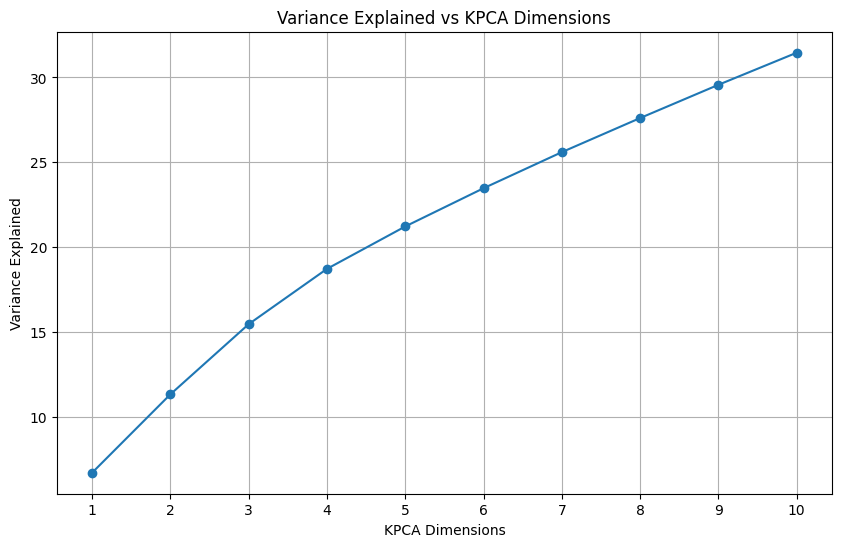

In [17]:
import matplotlib.pyplot as plt

# Plot the variance explained versus KPCA dimensions
plt.figure(figsize=(10, 6))
plt.plot(kpca_dimensions, variance_explained, marker='o', linestyle='-')
plt.title('Variance Explained vs KPCA Dimensions')
plt.xlabel('KPCA Dimensions')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.xticks(kpca_dimensions)
plt.show()


**Observations:**
1. **Initial Linear Increase:** Initially, as we increase the number of KPCA dimensions from 1 to 3, the variance explained increases linearly. This means that adding more dimensions leads to a significant increase in the variance explained by the KPCA components.
2. **Diminishing Returns:** After reaching around KPCA dimension 3, we notice that while the variance explained continues to increase, the rate of increase starts to slow down. This indicates that adding additional dimensions beyond 3 contributes less and less to explaining the variance in the data.
3. **Increasing Slope with Diminished Rate:** Despite the diminishing rate of increase, the slope of the curve continues to rise. This suggests that each additional dimension still contributes to explaining more variance, but the marginal benefit diminishes with each added dimension.
4. **Overall Trend:** The overall trend of the plot suggests that while increasing the number of dimensions does increase the variance explained, there comes a point where the additional dimensions add less value.


### **Reference:**
1. https://chat.openai.com/
2. https://www.wikipedia.org/
4. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html
3. webpages that I have mentioned above.



---



---


# --------------------------------------------------------------------**End**------------------------------------------------------------------

---



---

